# Single Image Denoising

In [32]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))



from utils.utils_train import  train_network_wrapper
from utils.utils_demo_growth import MT_perform_traversal, MT_denoise_local
from utils.utils_images import image_to_patches, patches_to_image_with_positions, preprocess_images, get_patches_from_images, flatten_patches

import pickle

# get data

In [ ]:
manifold_type = 'patches'
save_dir = '/data/shiyu/projects/MT/MT_code/images/single_image_denoising'


image_dir = '/data/shiyu/projects/MT/MT_code/images/image_data/single_image_data/'
img_name = '0801.png'
image_path = os.path.join(image_dir, img_name)



# Load the image
img = Image.open(image_path)
img_array = np.array(img)
print(f'image size is {img_array.shape}')


sigma = 0.1 #noise level
images = [img_array] #single image denoising



is_single_image = True
if is_single_image:
    idx_test  = 0


orig_img_scaled, img_scaled, noisy_images, clean_images = preprocess_images(images=images, start_idx=0, num_imgs=1, sigma=sigma)
clean_patches, noisy_patches, clean_positions, noisy_positions, N_patches_per_img = get_patches_from_images(clean_images=clean_images, noisy_images=noisy_images, patch_size=8, stride=4)
clean_patches_flattened, noisy_patches_flattened = flatten_patches(clean_patches=clean_patches, noisy_patches=noisy_patches)



#shuffle the data
permutation = np.random.permutation(len(noisy_patches_flattened))
shuffled_clean_patches = clean_patches_flattened[permutation, :]
shuffled_noisy_patches = noisy_patches_flattened[permutation, :]



X_natural_train = shuffled_clean_patches.T
X_train = shuffled_noisy_patches.T
print(f'X_train shape is {X_train.shape}')

N_train = X_train.shape[1]
print(f'N_train = {N_train}')



#dimensions
D = clean_patches[0].shape[1] * clean_patches[0].shape[2] * clean_patches[0].shape[3]
d = 4

print(f'D = {D}, d = {d}')

Total number of original images: len(img_scaled_orig) = 1
Total number of RGB images: len(img_scaled) for training = 1
Number of clean images: len(clean_images) = 1
Number of noisy images: len(noisy_images) = 1
Number of total patches in noisy images: 172042
X_train shape is (192, 172042)
N_train = 172042
D = 192, d = 4


In [40]:
print(f'image size is {img_array.shape}')

image size is (1356, 2040, 3)


# train denoisers

In [3]:
# define hyperparams
R_is_const_list = [False, True]

R_denoising_list = [np.sqrt(2.06 * sigma**2 * D), np.sqrt(2.06 * sigma**2 * D)]

R_1st_order_nbrs_list = [np.sqrt(2.39 * sigma**2 * D), np.sqrt(2.39 * sigma**2 * D)]

d_parallel_list = [np.sqrt(20 * sigma**2 * d), np.sqrt(20 * sigma**2 * d)]

prod_coeff_list = [1.2, 1.2]

exp_coeff_list = [1/2, 1/2]

name_list = ["NETWORK_1", "NETWORK_2"]

network_params_list = []
errors_list = []

In [4]:



for i in range(len(name_list)):
    print(f"TRAINING {name_list[i]}")
    network_params, errors = train_network_wrapper(R_is_const_list[i], R_denoising_list[i], R_1st_order_nbrs_list[i], d_parallel_list[i], prod_coeff_list[i], exp_coeff_list[i], name_list[i],
                                                   D, d, sigma, 
                                                   N_train, X_train, X_natural_train, batch_size=4000)
    network_params_list.append(network_params)
    errors_list.append(errors)
    print("~~~~~~~~~~~~\n \n \n ")
    
    

with open(os.path.join(save_dir, f'single_image_network_params_list.pkl'), 'wb') as f:
    pickle.dump(network_params_list, f)



with open(os.path.join(save_dir, f'single_image_errors_list.pkl'), 'wb') as f:
    pickle.dump(errors_list, f)

TRAINING NETWORK_1
TOTAL TIME =  4.495253086090088
4000 samples processed...
TOTAL TIME =  8.856654167175293
8000 samples processed...
TOTAL TIME =  11.439899682998657
12000 samples processed...
TOTAL TIME =  15.961928606033325
16000 samples processed...
TOTAL TIME =  18.069169282913208
20000 samples processed...
TOTAL TIME =  19.85447597503662
24000 samples processed...
TOTAL TIME =  22.11791968345642
28000 samples processed...
TOTAL TIME =  26.36989140510559
32000 samples processed...
TOTAL TIME =  27.786118268966675
36000 samples processed...
TOTAL TIME =  32.46155285835266
40000 samples processed...
TOTAL TIME =  32.60653519630432
44000 samples processed...
TOTAL TIME =  36.80103015899658
48000 samples processed...
TOTAL TIME =  37.25734043121338
52000 samples processed...
TOTAL TIME =  39.47075939178467
56000 samples processed...
TOTAL TIME =  42.57251477241516
60000 samples processed...
TOTAL TIME =  48.782480239868164
64000 samples processed...
TOTAL TIME =  46.00663757324219
68

# Analyze Network

## training error curve

In [28]:
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})

NETWORK_1
Number of landmarks: 16992

Number of first-order edges: 160872

Number of zero-order edges: 19296



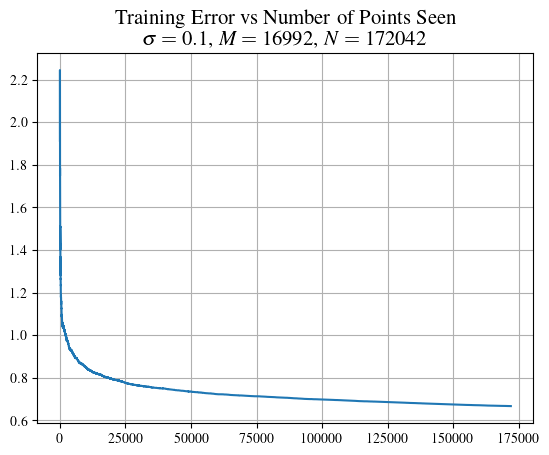

----------------------------------------------------------------------------------------------------------------------
NETWORK_2
Number of landmarks: 13507

Number of first-order edges: 44965

Number of zero-order edges: 14316



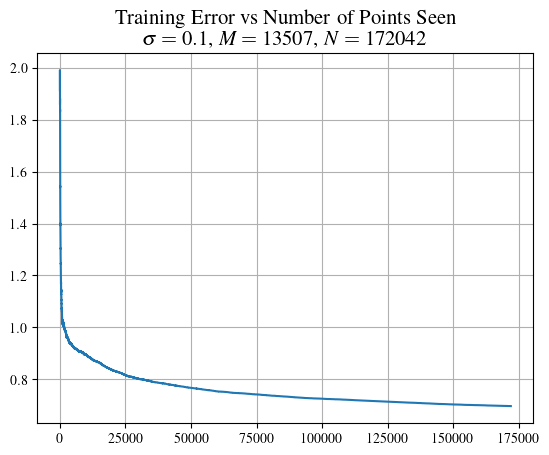

----------------------------------------------------------------------------------------------------------------------


In [31]:
for net_idx in range(len(R_denoising_list)):
    
    print(f'{name_list[net_idx]}')

    (mean_MT_SE, mean_data_SE, all_MT_SE) = errors_list[net_idx]
    [local_params, nbrs_info, misc] = network_params_list[net_idx]

    
    (Q, T, S_collection, P, Xi)           = local_params
    (N1, W1, N0, W0)                      = nbrs_info
    (tangent_colors,D, d, M, P)           = misc


    print(f"Number of landmarks: {M}\n")
    print(f"Number of first-order edges: {sum(len(inner_list) for inner_list in N1)}\n")
    print(f"Number of zero-order edges: {sum(len(inner_list) for inner_list in N0)}\n")


    plt.figure()
    plt.plot(mean_MT_SE, label='mean_MT_SE')
    plt.grid()
    plt.title(f'Training Error vs Number of Points Seen\n$\\sigma={sigma}$, $M={M}$, $N={N_train}$', fontsize=15)
    plt.savefig(f"single_image_trainingcurve_{net_idx}.pdf", bbox_inches="tight")
    plt.show()

    print('----------------------------------------------------------------------------------------------------------------------')

In [26]:
(172042//10000) * 10000

170000

# denoising

In [7]:

denoised_patches_list = []

for net_idx in range(len(R_denoising_list)):

    print(f'{name_list[net_idx]}')
    [local_params, nbrs_info, misc] = network_params_list[net_idx]
    
    (Q, T, S_collection, P, Xi)           = local_params
    (N1, W1, N0, W0)                      = nbrs_info
    (tangent_colors,D, d, M, P)           = misc


    denoised_patches_flattened = np.zeros(noisy_patches_flattened.shape)

    
    #denoise one image
    for n in range(N_train):
        x = noisy_patches_flattened[n,:]
        q_mt, _, _, _, mt_mults = MT_perform_traversal(x, Q, T, N1, W1,Xi, N0, W0, calc_mults=False)
        x_mt_hat = MT_denoise_local(x, Q, T, q_mt)
        denoised_patches_flattened[n,:] = x_mt_hat

    denoised_patches = denoised_patches_flattened.reshape(-1, 8, 8, 3)
    denoised_patches_list.append(denoised_patches)

NETWORK_1
NETWORK_2


# plot

In [9]:

import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"]  # Using Times instead of Computer Modern to avoid font issues
})

NETWORK_1
NETWORK_2


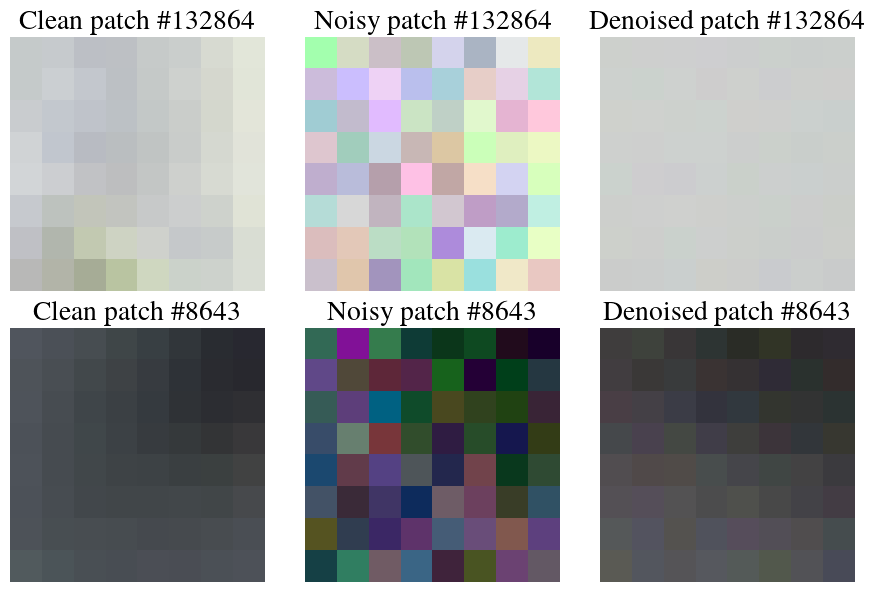

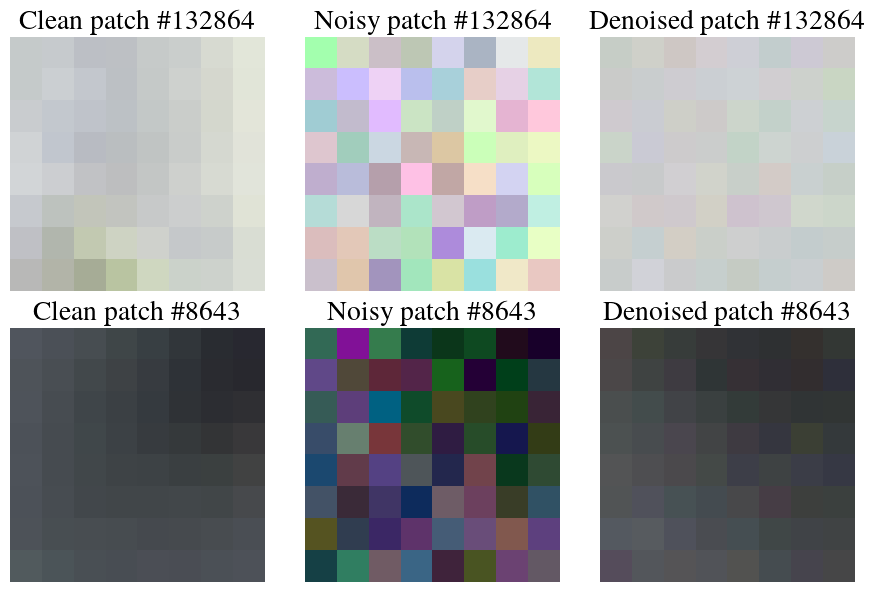

In [37]:
#plot patches

idx1 = np.random.randint(0, N_train)
idx2 = np.random.randint(0, N_train)


for net_idx in range(len(R_denoising_list)):
    print(f'{name_list[net_idx]}')

    denoised_patches = denoised_patches_list[net_idx]

    plt.figure(figsize=(9,6))

    plt.subplot(231)
    plt.imshow(np.clip(clean_patches[idx_test][idx1],0.0,1.0))
    plt.title(r'Clean patch $\#%d$' % idx1, fontsize=20)
    plt.axis('off')

    plt.subplot(232)
    plt.imshow(np.clip(noisy_patches[idx_test][idx1],0.0,1.0))
    plt.title(r'Noisy patch $\#%d$' % idx1, fontsize=20)
    plt.axis('off')

    plt.subplot(233)
    plt.imshow(np.clip(denoised_patches[idx1],0.0,1.0))
    plt.title(r'Denoised patch $\#%d$' % idx1, fontsize=20)
    plt.axis('off')

    plt.subplot(234)
    plt.imshow(np.clip(clean_patches[idx_test][idx2],0.0,1.0))
    plt.title(r'Clean patch $\#%d$' % idx2, fontsize=20)
    plt.axis('off')

    plt.subplot(235)
    plt.imshow(np.clip(noisy_patches[idx_test][idx2],0.0,1.0))
    plt.title(r'Noisy patch $\#%d$' % idx2, fontsize=20)
    plt.axis('off')

    plt.subplot(236)
    plt.imshow(np.clip(denoised_patches[idx2],0.0,1.0))
    plt.title(r'Denoised patch $\#%d$' % idx2, fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"single_image_patches_{net_idx}.pdf", bbox_inches="tight")

NETWORK_1
noisy-orig-sqdist - denoised-orig-sqdist is 65207.95920962004
clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is 61464.31143457048
--------------------------------------------------------------------------------------------------


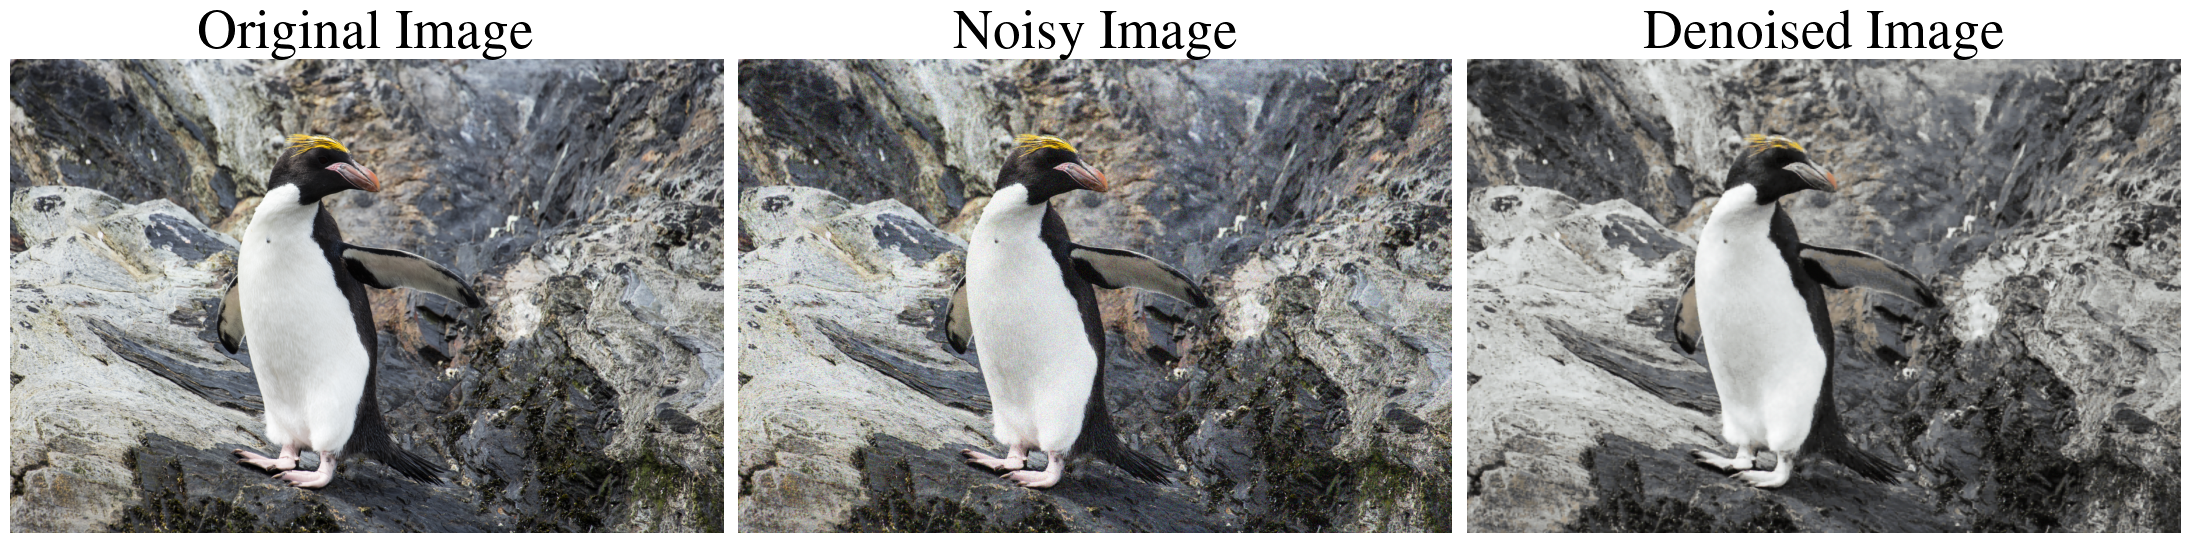

NETWORK_2
noisy-orig-sqdist - denoised-orig-sqdist is 62000.28825928798
clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is 58256.20974840205
--------------------------------------------------------------------------------------------------


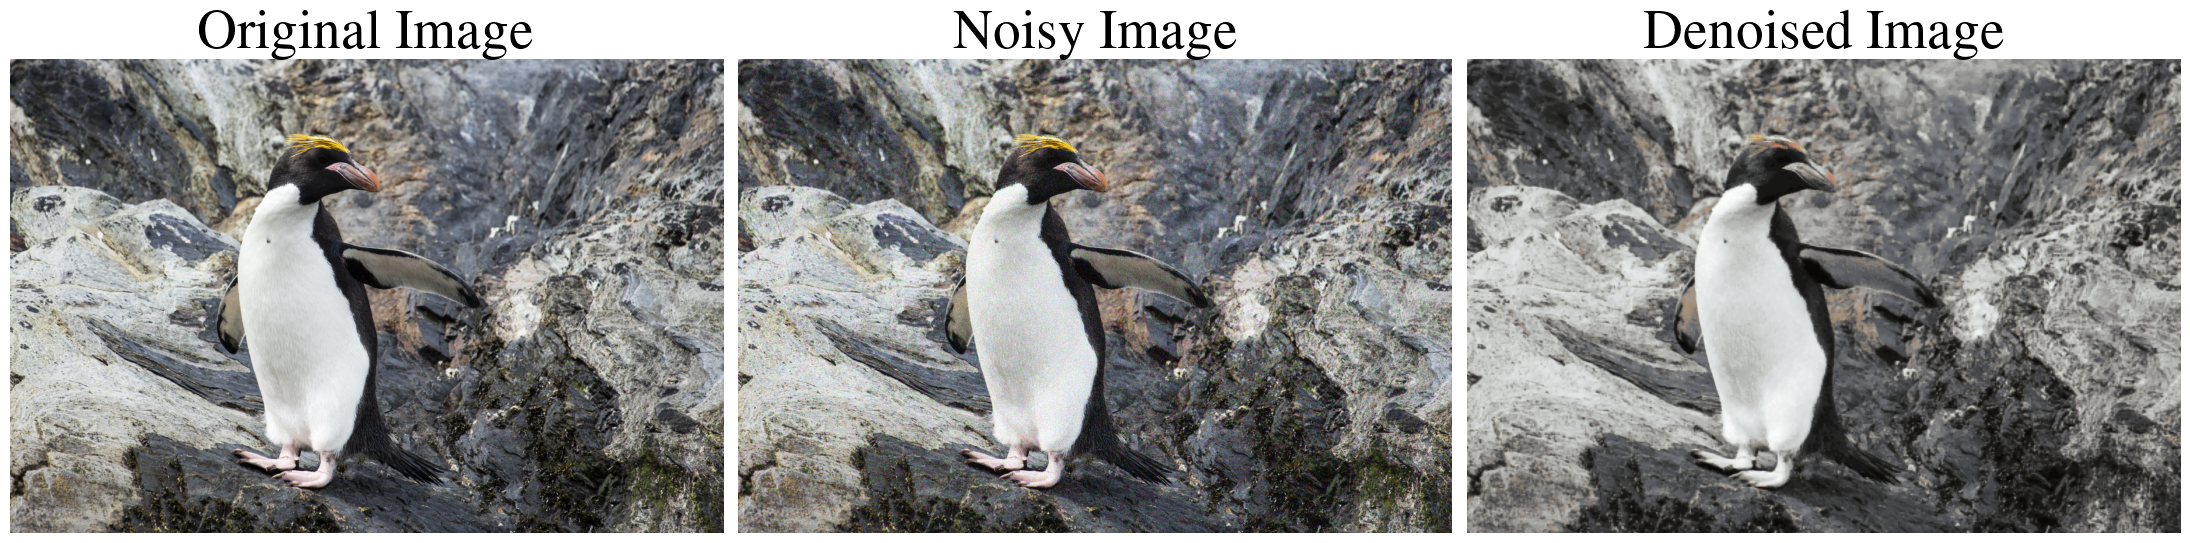

In [ ]:

img_scaled_clip = np.clip(img_scaled, 0.0, 1.0)
noisy_img_clip = np.clip(noisy_images, 0.0, 1.0)




for net_idx in range(len(R_denoising_list)):

    denoised_patches = denoised_patches_list[net_idx]
    denoised_image = patches_to_image_with_positions(denoised_patches, noisy_positions[idx_test], img_scaled[idx_test].shape[0], img_scaled[idx_test].shape[1])

    denoised_image_clip = np.clip(denoised_image, 0.0, 1.0) #denoised single image

    noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled[idx_test] - noisy_images[idx_test])**2) - np.sum((img_scaled[idx_test] - denoised_image)**2)
    clip_noisy_orig_sqdist_denoised_orig_sqdist = np.sum((img_scaled_clip[idx_test] - noisy_img_clip[idx_test])**2) - np.sum((img_scaled_clip[idx_test] - denoised_image_clip)**2)


    print(f'{name_list[net_idx]}')
    print(f'noisy-orig-sqdist - denoised-orig-sqdist is {noisy_orig_sqdist_denoised_orig_sqdist}')
    print(f'clip-noisy-orig-sqdist - clip-denoised-orig-sqdist is {clip_noisy_orig_sqdist_denoised_orig_sqdist}')
    print('--------------------------------------------------------------------------------------------------')

    plt.figure(figsize=(22, 9))

    plt.subplot(1, 3, 1)
    plt.imshow(img_scaled_clip[idx_test])
    plt.title(r'{Original Image}', fontsize=40)  # Bold text in LaTeX
    # plt.savefig(f"single_image_orig_img_{net_idx}.pdf", bbox_inches="tight")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img_clip[idx_test])
    plt.title(r'{Noisy Image}', fontsize=40)  # Bold text in LaTeX
    # plt.savefig(f"single_image_noisy_img_{net_idx}.pdf", bbox_inches="tight")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(denoised_image_clip)
    plt.title(r'{Denoised Image}', fontsize=40)  # Bold text in LaTeX
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"single_image_denoised_img_{net_idx}.pdf", bbox_inches="tight")
    plt.show()